# RNN - Forecasting - Frozen Dessert Product

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv('../input/frozen-dessert-production/Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [5]:
df.columns = ['Production']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


<AxesSubplot:xlabel='DATE'>

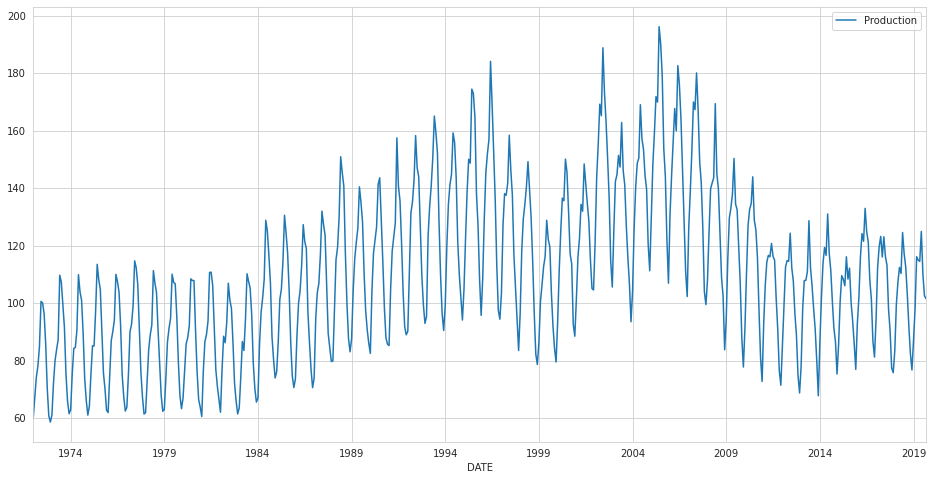

In [7]:
df.plot(figsize=(16,8))

- Seasonal data with a cyle of one year (12 months)
- We will select leanght as 12 and test size sould be bigger than that.
- Test size will be 18

In [8]:
test_size= 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
scaler = MinMaxScaler()

In [13]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [15]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [16]:
X, y = generator[0]

In [17]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


In [19]:
n_features = 1

In [21]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

In [26]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [27]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

2021-11-14 08:13:20.175580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
543/543 [==============================] - 6s 8ms/step - loss: 0.0183 - val_loss: 0.0021
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 3/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 4/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 5/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 6/20
543/543 [==============================] - 5s 8ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 7/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 8/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 9/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0036 - val_loss: 0.0093
Epoch 10/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0031 - val_loss: 0.0042

<AxesSubplot:>

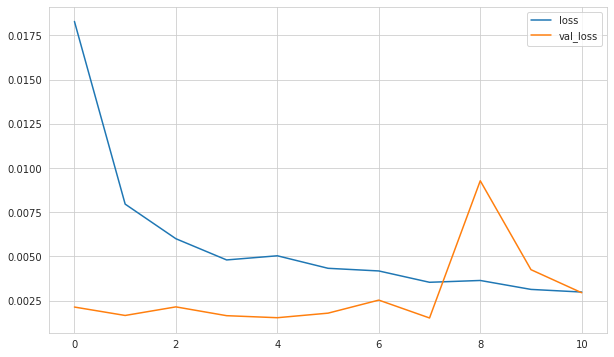

In [28]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [30]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

In [32]:
test

,Production,Predictions
DATE,,
2018-04-01,112.431,115.055
2018-05-01,110.354,118.867
2018-06-01,124.584,119.716
2018-07-01,117.222,114.104
2018-08-01,112.678,101.458
2018-09-01,103.312,82.660
2018-10-01,92.132,69.187
2018-11-01,82.435,61.851
2018-12-01,76.761,64.689


<AxesSubplot:xlabel='DATE'>

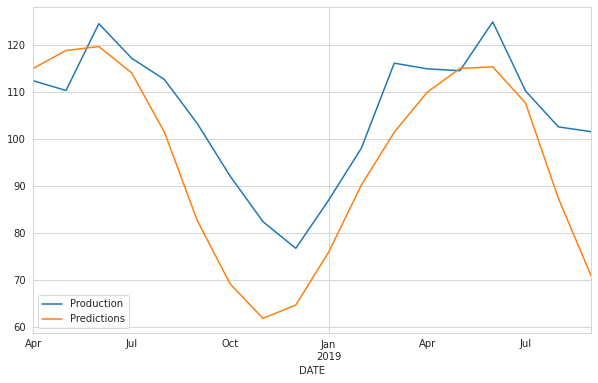

In [33]:
test.plot()

In [35]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [36]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: -0.05707648477487548 
mae: 11.321288367307545 
mse: 192.22644537352053 
rmse: 13.86457519628786


In [37]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [38]:
length = 18 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [39]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(generator, epochs=8)

Epoch 1/8
555/555 [==============================] - 7s 10ms/step - loss: 0.0229
Epoch 2/8
555/555 [==============================] - 6s 11ms/step - loss: 0.0075
Epoch 3/8
555/555 [==============================] - 5s 10ms/step - loss: 0.0045
Epoch 4/8
555/555 [==============================] - 5s 10ms/step - loss: 0.0034
Epoch 5/8
555/555 [==============================] - 5s 10ms/step - loss: 0.0031
Epoch 6/8
555/555 [==============================] - 6s 10ms/step - loss: 0.0029
Epoch 7/8
555/555 [==============================] - 6s 10ms/step - loss: 0.0030
Epoch 8/8
555/555 [==============================] - 6s 11ms/step - loss: 0.0028


In [40]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [41]:
forecast = scaler.inverse_transform(forecast)

In [42]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [43]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

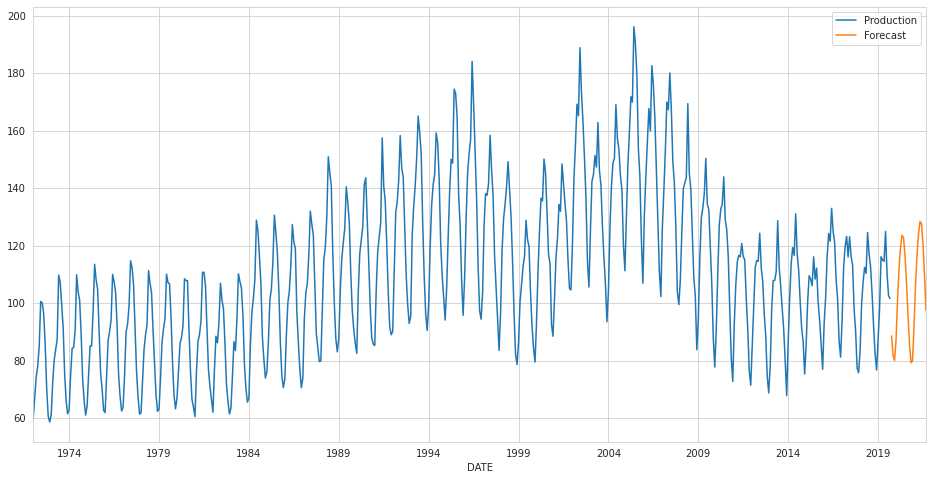

In [44]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

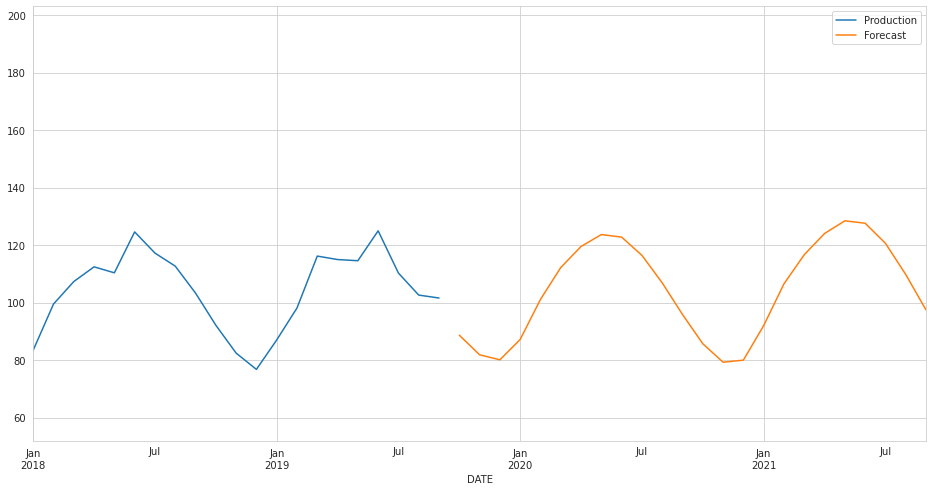

In [45]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')